<a href="https://colab.research.google.com/github/LucasPequenoSterzeck/Machine_Learning_LPS/blob/main/PyTorch_Jovian_ZeroToGANs/Class_02/MNIST_Train_Torch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook destined to train in mnist dataset

<img src='https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.rubylab.io%2Fimg%2Fmnist.png&f=1&nofb=1&ipt=2c80072f255a7c9df77ebd9c96dfec4279db25f4ae811a037ded496051009b67&ipo=images'/>

About: The MNIST database is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets


In [ ]:
# Lib's torch import:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
# parameters
batch_size = 128
learning_rate = 0.001

# others
input_size = 28*28 # Pixel's Weight x Pixel's Length
num_classes = 10 # 0 to 9 - 10 classes/possibilites

In [ ]:
# Donwload the dataset MINIST
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Train, val and test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label of image:  3
Dimension:  torch.Size([1, 28, 28])


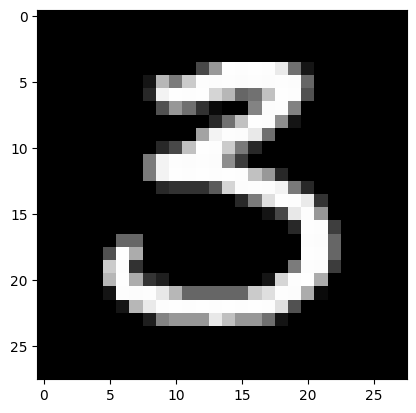

In [ ]:
# test data:
img, lab = train_ds[0]
print('Label of image: ',lab)
print('Dimension: ',img.shape)
plt.imshow(img[0], cmap='gray')


# Extend a Class of TORCH.NN

In [ ]:
# Creating class MnistModel from Torch.NN

class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out

  def training_step(self, batch):
    img, lab = batch
    out = self(img)
    loss = F.cross_entropy(out, lab)
    return loss

  def validation_step(self, batch):
    img, lab = batch
    out = self(img)
    loss = F.cross_entropy(out, lab)
    acc = accuracy(out, lab)
    return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_losses = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_losses.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(sefl, epoch, result):
    print(f"-> Epoch [{epoch+1}]  |  Val_loss: {round(result['val_loss'],4)}  |  Val_acc: {round(result['val_acc'],4)}")

# declare the model
model = MnistModel()

# Sub classes
def accuracy(out, lab):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == lab).item() / len(preds))

def evaluate(model, val_loader):
  out = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(out)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  opt = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()
    # Validation Phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
evaluate(model, val_loader)

{'val_loss': 2.2890632152557373, 'val_acc': 0.107421875}

In [ ]:
history = fit(15, 0.001, model, train_loader, val_loader)

-> Epoch [1]  |  Val_loss: 1.9342  |  Val_acc: 0.6271
-> Epoch [2]  |  Val_loss: 1.6719  |  Val_acc: 0.734
-> Epoch [3]  |  Val_loss: 1.4757  |  Val_acc: 0.7681
-> Epoch [4]  |  Val_loss: 1.3272  |  Val_acc: 0.7875
-> Epoch [5]  |  Val_loss: 1.2127  |  Val_acc: 0.8019
-> Epoch [6]  |  Val_loss: 1.1225  |  Val_acc: 0.8103
-> Epoch [7]  |  Val_loss: 1.05  |  Val_acc: 0.8156
-> Epoch [8]  |  Val_loss: 0.9904  |  Val_acc: 0.8211
-> Epoch [9]  |  Val_loss: 0.9407  |  Val_acc: 0.8245
-> Epoch [10]  |  Val_loss: 0.8986  |  Val_acc: 0.8281
-> Epoch [11]  |  Val_loss: 0.8624  |  Val_acc: 0.8313
-> Epoch [12]  |  Val_loss: 0.8311  |  Val_acc: 0.8339
-> Epoch [13]  |  Val_loss: 0.8036  |  Val_acc: 0.8367
-> Epoch [14]  |  Val_loss: 0.7792  |  Val_acc: 0.8396
-> Epoch [15]  |  Val_loss: 0.7575  |  Val_acc: 0.8413


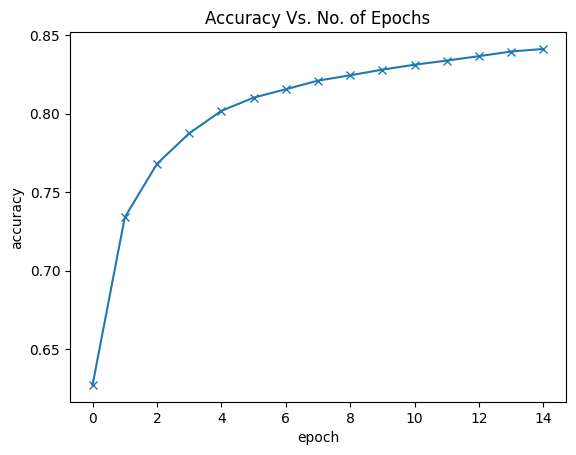

In [ ]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of Epochs')
plt.show()

In [ ]:
# Evaluate on teste dataset:
result = evaluate(model, test_loader)
result

{'val_loss': 0.7219929695129395, 'val_acc': 0.853710949420929}

# Prediction

label:  1
Predicted label: 3 | with 22.91 %

NOOO! Label predicted WRONG



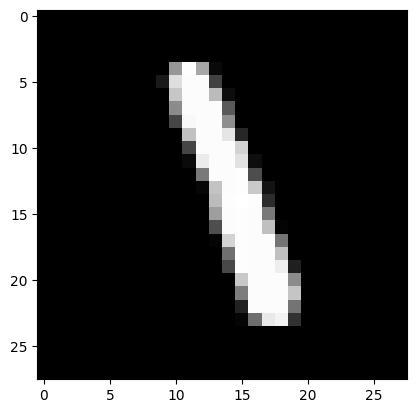

In [ ]:
def predict_img(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  pred_label = preds[0].item()
  soft = F.softmax(yb, dim=1)[0][pred_label].item()
  return pred_label, soft

from datetime import datetime

img, lab = test_ds[datetime.now().second]
pred, prob = predict_img(img, model)
print('label: ',lab)
print(f'Predicted label: {pred} | with {round(prob*100,2)} %')
print('\nNICEEE! Label predicted CORRECT\n' if lab == pred else '\nNOOO! Label predicted WRONG\n')
plt.imshow(img[0], cmap='gray')